In [2]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00397/LasVegasTripAdvisorReviews-Dataset.csv", sep=';')

In [3]:
df.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday


In [4]:
df['Score'].value_counts(normalize=True)

5    0.450397
4    0.325397
3    0.142857
2    0.059524
1    0.021825
Name: Score, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df['Score'], random_state=1337)

In [6]:
train['Score'].value_counts(normalize=True)

5    0.449132
4    0.325062
3    0.143921
2    0.059553
1    0.022333
Name: Score, dtype: float64

In [7]:
def wrangle(X):

    X = X.copy()

    def country_aggregation(row): #reduce number of country categories to 4. 'USA', 'Canada', 'UK', and all else 'other'.
        if row['User country'] != "USA" and row['User country'] != 'Canada' and row['User country'] != 'UK':
            return "Other"
        else:
            return row['User country']

    def score_aggregation(row):
        if row['Score'] == 5:
            return "Excellent"
        elif row['Score'] == 4 or row['Score'] == 3:
            return "Average"
        else:
            return "Bad"

    X['User country'] = X.apply(country_aggregation, axis=1)

    #if not predict: #only modify score column if passing in training/test data. Do not run when running real predictions!
    X['Score'] = X.apply(score_aggregation, axis=1)
    X = X.drop(['Member years'], axis=1)

    X['Hotel stars'] = X['Hotel stars'].str.replace("," , ".").astype(str)
    X['Hotel stars'] = X['Hotel stars'].replace({"3": 1, "3.5": 2, "4": 3, "4.5": 4, "5": 5}).astype(int) #ordinal encoding

    X.loc[(X['Hotel name'] == "Trump International Hotel Las Vegas") |  #Trump international is a hotel only, no casino.
          (X['Hotel name'] == "Marriott's Grand Chateau") | #Marriott's Grand Chateau is a hotel only, no casino.
          (X['Hotel name'] == "Wyndham Grand Desert"), 'Casino'] = "NO" #Wyndham Grand Desert is a hotel only, no casino.

    return X

In [8]:
train = wrangle(train)
test = wrangle(test)

In [9]:
from sklearn.metrics import accuracy_score

majority_class = train['Score'].mode()[0]
y_pred = [majority_class] * len(train['Score'])

print("Train baseline accuracy is: ", accuracy_score(train['Score'], y_pred))

Train baseline accuracy is:  0.46898263027295284


In [10]:
majority_class = test['Score'].mode()[0]
y_pred = [majority_class] * len(test['Score'])

print("Test baseline accuracy is: ", accuracy_score(test['Score'], y_pred))

Test baseline accuracy is:  0.46534653465346537


In [11]:
target = 'Score'

train_features = train.drop([target], axis=1)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

categorical_features = train_features.select_dtypes(exclude='number').nunique().index.tolist()


features = numeric_features + categorical_features

features_logistic = categorical_features.copy()
features_logistic.append('Hotel stars') #add hotel stars to features list, so we can specify to onehotencoder that we want to encode it, even though it is numeric(as we already did ordinal encoding on it)

In [12]:
y_train = train[target]
X_train = train[features]
X_test = test[features]
y_test = test[target]

In [13]:
X_train.shape

(403, 18)

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

#When hyperparamater tuning, set tune to "True", and mark each model that we want to tune to "True".
tune = False
forest = False
logistic = False
xgboost = False

forest_distributions = {
    'model__n_estimators': range(250, 500, 50),
    'model__max_depth': range(3, 14),
    'model__max_features': range(2, 14),
    'model__min_samples_leaf': range(2, 4)
}
logistic_distributions = {
    'kbest__k': range(1, 20),
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

xgboost_distributions = {
    'model__n_estimators': [75, 100, 125, 150, 175],
    'model__max_depth': [6, 7, 8, 9, 10, 11, 12, 13],
    'model__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.12, 0.14, 0.16],
    'model__min_child_leaf':[1, 2, 3],
    'model__min_child_weight': [1, 2, 3, 4],
    'model__colsample_bytree':[0.2, 0.3, 0.4, 0.50, 0.60, 0.70],
    'model__subsample':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'model__gamma':[0],
    'model__scale_pos_weight': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                                75, 80, 85, 90, 95, 100]
 }

if tune: #If we are hyperparamater tuning, pass no parameters into estimators and find paramaters via GridSearchCV / RandomizedSearchCV

    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('model', RandomForestClassifier(random_state=1337))])

    logistic_pipeline = Pipeline([('encoder', ce.OneHotEncoder()),
                                ('scaler', StandardScaler()),
                                ('kbest', SelectKBest()),
                                ('model', LogisticRegression(random_state=1337))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('model', XGBClassifier(seed=1337))])

    forest_search = GridSearchCV(
        forest_pipeline,
        param_grid=forest_distributions,
        cv=3,
        scoring='neg_log_loss', #good out of the box scoring metric for multiclass hyperparameter tuning
        verbose=10,
        n_jobs=15
    )
    logistic_search = GridSearchCV(
        logistic_pipeline,
        param_grid=logistic_distributions,
        cv=3,
        scoring='neg_log_loss', #good out of the box scoring metric for multiclass hyperparameter tuning
        verbose=10,
        n_jobs=15
    )
    xgboost_search = RandomizedSearchCV(
        estimator=xgboost_pipeline,
        param_distributions=xgboost_distributions,
        n_iter=10000,
        cv=3,
        scoring='neg_log_loss', #good out of the box scoring metric for multiclass hyperparameter tuning
        verbose=10,
        random_state=1337,
        n_jobs=15
    )

    X_train, y_train = RandomOverSampler(sampling_strategy='not majority').fit_resample(X_train, y_train)

    if forest:
        forest_search.fit(X_train, y_train)
        forest_train_pred = forest_search.predict(X_train)
        forest_test_pred = forest_search.predict(X_test)
        forest_test_pred_proba = forest_search.predict_proba(X_test)

    if logistic:
        logistic_search.fit(X_train, y_train)
        logistic_train_pred = logistic_search.predict(X_train)
        logistic_test_pred = logistic_search.predict(X_test)
        logistic_test_pred_proba = logistic_search.predict_proba(X_test)

    if xgboost:
        xgboost_search.fit(X_train, y_train)
        xgboost_train_pred = xgboost_search.predict(X_train)
        xgboost_test_pred = xgboost_search.predict(X_test)
        xgboost_test_pred_proba = xgboost_search.predict_proba(X_test)

    #When hyperparameter tuning, pass our best estimators into votingclassifier. Only run when all 3 models are being tuned.
    if forest and logistic and xgboost:
        voting_model = VotingClassifier(estimators=[('forest', forest_search.best_estimator_), #VotingClassifier is Soft Voting/Majority Rule classifier for unfitted estimators
                                                    ('logistic', logistic_search.best_estimator_),
                                                    ('xgboost', xgboost_search.best_estimator_),],
                                        voting='soft', weights=[2, 1, 2]) #soft voting per recommendation from sklearn documentation, when used on tuned classifiers.
        voting_model.fit(X_train, y_train)

else: #If we are not hyperparameter tuning, pass in our best params(from previous tuning runs).
    forest_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                            ('model', RandomForestClassifier(random_state=1337,
                                                        max_depth=13,
                                                        max_features=11,
                                                        min_samples_leaf=2,
                                                        n_estimators=450))])
    logistic_pipeline = Pipeline([('encoder', ce.OneHotEncoder(cols=features_logistic)), #use features list which contains "Hotel stars" so that it gets properly encoded.
                                ('scaler', StandardScaler()),
                                ('kbest', SelectKBest(k=19)),
                                ('model', LogisticRegression(random_state=1337, C=0.01))])

    xgboost_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                                ('model', XGBClassifier(random_state=1337, n_estimators=175, min_child_weight=1,
                                                min_child_leaf=2, max_depth=11, learning_rate=0.04,
                                                gamma=0, subsample=0.8, colsample_bytree=0.3, scale_pos_weight=100))])


    X_train, y_train = RandomOverSampler(sampling_strategy='not majority').fit_resample(X_train, y_train) #over sample all but the majority class

    forest_pipeline.fit(X_train, y_train)
    forest_train_pred = forest_pipeline.predict(X_train)
    forest_test_pred = forest_pipeline.predict(X_test)
    forest_test_pred_proba = forest_pipeline.predict_proba(X_test)

    logistic_pipeline.fit(X_train, y_train)
    logistic_train_pred = logistic_pipeline.predict(X_train)
    logistic_test_pred = logistic_pipeline.predict(X_test)
    logistic_test_pred_proba = logistic_pipeline.predict_proba(X_test)

    xgboost_pipeline.fit(X_train, y_train)
    xgboost_train_pred = xgboost_pipeline.predict(X_train)
    xgboost_test_pred = xgboost_pipeline.predict(X_test)
    xgboost_test_pred_proba = xgboost_pipeline.predict_proba(X_test)

    voting_model = VotingClassifier(estimators=[('forest', forest_pipeline), #VotingClassifier is Soft Voting/Majority Rule classifier for unfitted estimators
                                                ('logistic', logistic_pipeline),
                                                ('xgboost', xgboost_pipeline),],
                                    voting='soft') #soft voting per recommendation from sklearn documentation, when used on tuned classifiers.
    voting_model.fit(X_train, y_train)

In [15]:
#pickle the model
from joblib import dump
dump(voting_model, 'voting_model.joblib', compress=True)

['voting_model.joblib']

In [16]:
#print package versions for pipenv
import joblib
import sklearn
import category_encoders as ce
import xgboost
import imblearn
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')
print(f'imblearn=={imblearn.__version__}')



joblib==0.14.1
scikit-learn==0.22.2.post1
category_encoders==2.1.0
xgboost==1.0.2
imblearn==0.6.2


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve
if tune:
    target_names = ['Average', 'Bad', 'Excellent']

    if forest:
        print(forest_search.best_params_, '\n')
        print("Best Random Forest CV score: ", forest_search.best_score_, '\n')
        print("Random forest ROC-AUC: ", roc_auc_score(y_test, forest_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
        print(classification_report(y_test, forest_test_pred, target_names=target_names), '\n')

        print('\n')

    if logistic:
        print(logistic_search.best_params_, '\n')
        print("Best logistic regression CV score: ", logistic_search.best_score_, '\n')
        print("Logistic regression ROC-AUC: ", roc_auc_score(y_test, logistic_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
        print(classification_report(y_test, logistic_test_pred, target_names=target_names), '\n')

        print('\n')

    if xgboost:
        print(xgboost_search.best_params_, '\n')
        print("Best xgboost CV score: ", xgboost_search.best_score_, '\n')
        print("Xgboost ROC-AUC: ", roc_auc_score(y_test, xgboost_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
        print(classification_report(y_test, xgboost_test_pred, target_names=target_names), '\n')

        print('\n')

    if forest and logistic and xgboost:
        print("Voting classifier, final accuracy score on test set: ", voting_model.score(X_test, y_test))

        combined_model = voting_model.predict_proba(X_test)
        print("Voting classifier, final ROC AUC on test set: ", roc_auc_score(y_test, combined_model, multi_class='ovr', labels=target_names))
else:
    target_names = ['Average', 'Bad', 'Excellent']
    print("Random forest ROC-AUC: ", roc_auc_score(y_test, forest_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
    print(classification_report(y_test, forest_test_pred, target_names=target_names))

    print('\n')

    print("Logistic regression ROC-AUC: ", roc_auc_score(y_test, logistic_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
    print(classification_report(y_test, logistic_test_pred, target_names=target_names))

    print('\n')

    print("Xgboost ROC-AUC: ", roc_auc_score(y_test, xgboost_test_pred_proba, multi_class='ovr', labels=target_names), '\n')
    print(classification_report(y_test, xgboost_test_pred, target_names=target_names))

    print('\n')

    print("Voting classifier, final accuracy score on test set: ", voting_model.score(X_test, y_test))

    combined_model = voting_model.predict_proba(X_test)
    print("Voting classifier, final ROC AUC on test set: ", roc_auc_score(y_test, combined_model, multi_class='ovr', labels=target_names))

Random forest ROC-AUC:  0.7010360544292188 

              precision    recall  f1-score   support

     Average       0.57      0.55      0.56        47
         Bad       0.31      0.50      0.38         8
   Excellent       0.48      0.43      0.45        46

    accuracy                           0.50       101
   macro avg       0.45      0.50      0.46       101
weighted avg       0.50      0.50      0.50       101



Logistic regression ROC-AUC:  0.6103605551769339 

              precision    recall  f1-score   support

     Average       0.59      0.43      0.49        47
         Bad       0.16      0.38      0.22         8
   Excellent       0.50      0.52      0.51        46

    accuracy                           0.47       101
   macro avg       0.42      0.44      0.41       101
weighted avg       0.51      0.47      0.48       101



Xgboost ROC-AUC:  0.6821405168030156 

              precision    recall  f1-score   support

     Average       0.59      0.64      0.61 

In [18]:
###While this is a good way to evaluate the estimator we are passing in, unless using a 3 way train/validate/test split, this should not be used for feature selection.
###Instead, passing in an unfit estimator and specifying the amount of CV rounds will allow us to see more generalized permutation importance.
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    xgboost_pipeline.named_steps.model, #prefit estimator
    scoring='roc_auc_ovo',
    n_iter=300,
    random_state=1337
)

permuter.fit(xgboost_pipeline.named_steps.encoder.transform(X_test), y_test)
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

c:\users\user\venv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\user\venv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0369 ± 0.0436,Nr. hotel reviews
0.0204 ± 0.0308,Hotel name
0.0187 ± 0.0230,Hotel stars
0.0143 ± 0.0133,User country
0.0112 ± 0.0232,Review weekday
0.0104 ± 0.0162,User continent
0.0084 ± 0.0268,Nr. rooms
0.0069 ± 0.0397,Nr. reviews
0.0040 ± 0.0057,Free internet
0.0037 ± 0.0249,Traveler type


In [19]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    forest_pipeline.named_steps.model, #prefit estimator
    scoring='roc_auc_ovo',
    n_iter=300,
    random_state=1337
)

permuter.fit(forest_pipeline.named_steps.encoder.transform(X_test), y_test)
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0331 ± 0.0431,Nr. reviews
0.0321 ± 0.0461,Hotel name
0.0213 ± 0.0313,Hotel stars
0.0153 ± 0.0494,Nr. hotel reviews
0.0148 ± 0.0065,Free internet
0.0119 ± 0.0187,Review weekday
0.0091 ± 0.0165,User country
0.0056 ± 0.0270,Nr. rooms
0.0045 ± 0.0157,Pool
0.0033 ± 0.0111,User continent


In [20]:
permuter = PermutationImportance(
    logistic_pipeline.named_steps.model, #prefit estimator
    scoring='roc_auc_ovo',
    n_iter=300,
    random_state=1337
)

X_test_encoded = logistic_pipeline.named_steps.encoder.transform(X_test)
X_test_scaled = logistic_pipeline.named_steps.scaler.transform(X_test_encoded)
X_test_final = logistic_pipeline.named_steps.kbest.transform(X_test_scaled)

selected_mask = logistic_pipeline.named_steps.kbest.get_support()
all_names = X_test_encoded.columns
selected_names = all_names[selected_mask]


permuter.fit(X_test_final, y_test)
feature_names = selected_names.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0188 ± 0.0420,Hotel name_18
0.0137 ± 0.0252,Nr. hotel reviews
0.0086 ± 0.0495,Review weekday_5
0.0072 ± 0.0227,Review weekday_2
0.0051 ± 0.0166,Helpful votes
0.0051 ± 0.0224,Casino_2
0.0040 ± 0.0216,Casino_1
0.0036 ± 0.0246,Hotel stars_3
0.0021 ± 0.0119,Free internet_1
0.0019 ± 0.0121,Hotel name_7


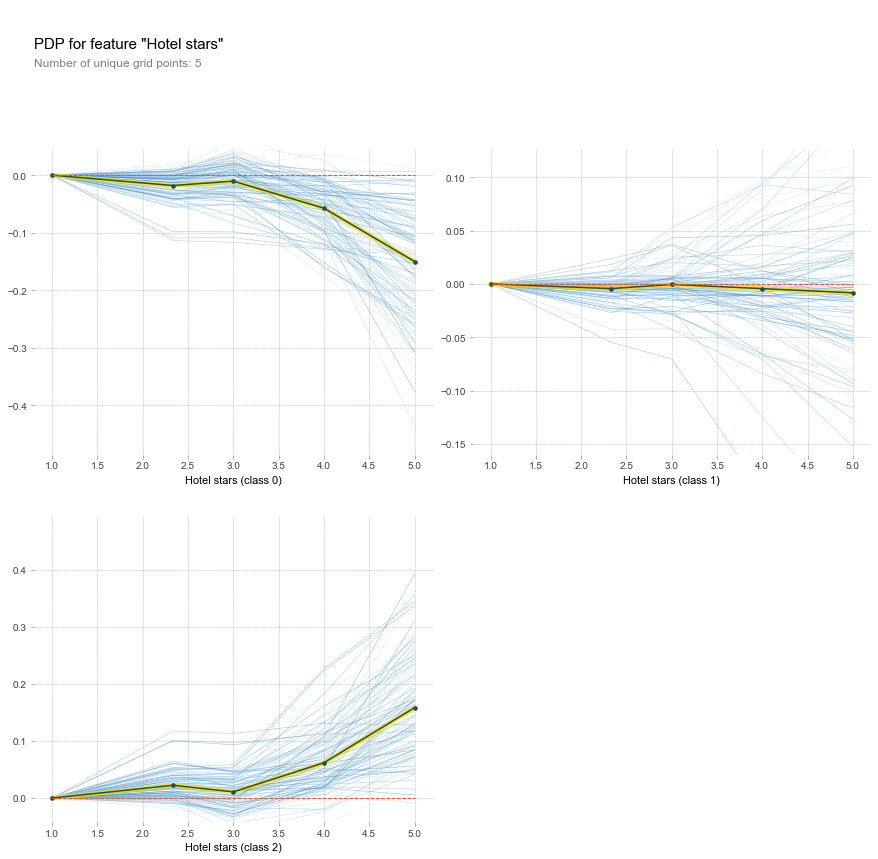

In [21]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Hotel stars'

isolated = pdp_isolate(
    model=forest_pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
    )

pdp_plot(isolated,feature_name=feature, plot_lines=True);

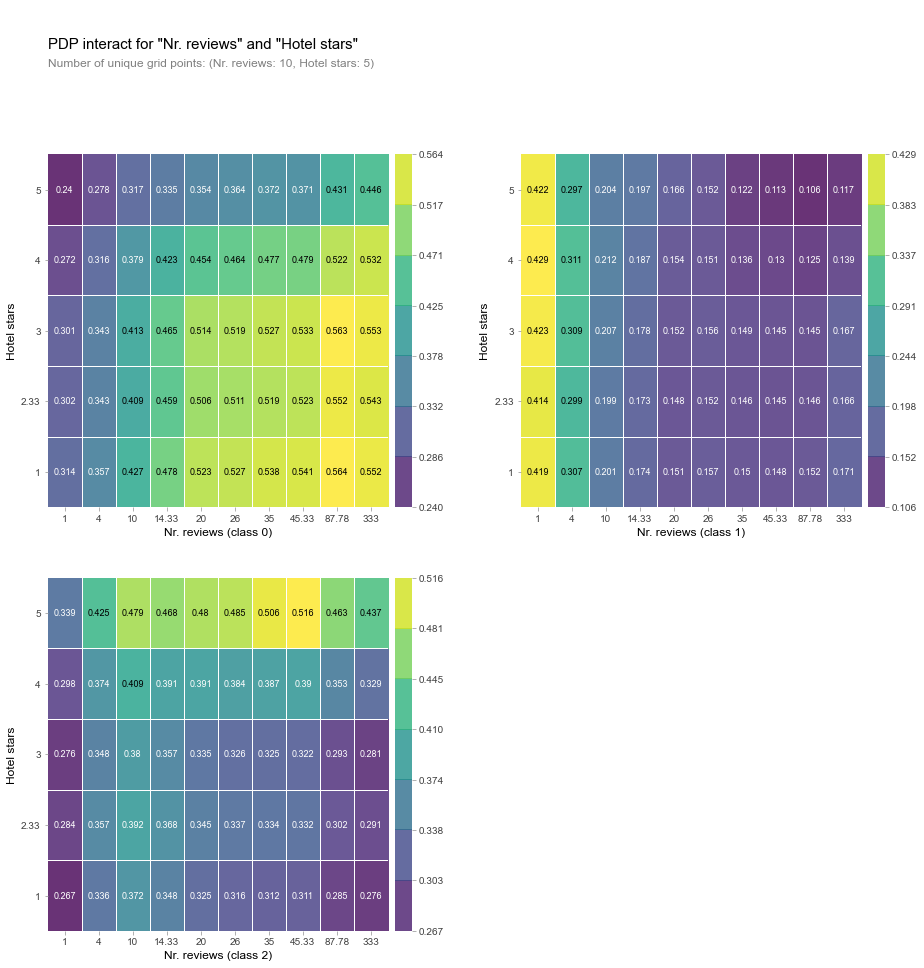

In [22]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features_interact = ['Nr. reviews', 'Hotel stars']

interaction = pdp_interact(
    model=forest_pipeline,
    dataset=X_test,
    model_features=X_test.columns,
    features=features_interact
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features_interact);


